# RQ2: Does Reddit sentiment correlate with Bitcoin volatility in short time intervals (1-minute/10-minutes/next-day) during 2018–2019? 


### 1.Compute negative sentiment score
### 2.Correlation + regression
### 3.Compute cross-correlation curve, also with negative time-scale


Import Librairies

In [28]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import statsmodels.formula.api as smf
import html
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import polars as pl

Load data

In [29]:
# load reddit data
# first 4 are for training, 5th for validation, 6th for testing

train1 = pd.read_csv("../data/reddit1.csv")
train2 = pd.read_csv("../data/reddit2.csv")
train3 = pd.read_csv("../data/reddit3.csv")
train4 = pd.read_csv("../data/reddit4.csv")
validate = pd.read_csv("../data/reddit6.csv")
test = pd.read_csv("../data/reddit5.csv")


In [30]:
# quick overview of the data columns and lines
print(train1.head())

print(f"train1: {len(train1)} rows")
print(f"train2: {len(train2)} rows")
print(f"train3: {len(train3)} rows")
print(f"train4: {len(train4)} rows")
print(f"validate: {len(validate)} rows")
print(f"test: {len(test)} rows")

                    timestamp  sentiment_score sentiment_label
0  2018-01-01T00:00:14.000000         0.074898             neu
1  2018-01-01T00:00:29.000000        -0.914421             neg
2  2018-01-01T00:00:36.000000         0.675613             pos
3  2018-01-01T00:00:58.000000         0.966026             pos
4  2018-01-01T00:01:10.000000         0.146835             neu
train1: 292404 rows
train2: 162244 rows
train3: 130209 rows
train4: 109912 rows
validate: 108976 rows
test: 86329 rows


In [31]:
#load bitcoin data
bitcoin = pd.read_csv("../data/btc_2018_2019.csv")
print(bitcoin.head())


                    timestamp      open      high       low     close  \
0  2018-01-01T00:00:00.000000  13840.53  13840.53  13819.04  13820.96   
1  2018-01-01T00:01:00.000000  13821.05  13888.90  13821.05  13850.67   
2  2018-01-01T00:02:00.000000  13888.91  13938.63  13850.01  13850.40   
3  2018-01-01T00:03:00.000000  13850.40  13933.94  13850.40  13894.25   
4  2018-01-01T00:04:00.000000  13894.26  13978.24  13879.83  13880.45   

      volume  
0   1.045522  
1  18.083867  
2   3.553685  
3   0.894357  
4  11.214208  


In [32]:
def prepare(df: pl.DataFrame):
    return (
        df.select(["timestamp", "sentiment_score"])
             .drop_nulls("sentiment_score")
             .with_columns(
                 pl.col("timestamp").dt.date().alias("date"),
                 pl.col("sentiment_score").alias("score"),
         )
    )

## Basic Exploratory Data Analysis

In [33]:
# Missing Values Analysis

print("MISSING VALUES ANALYSIS")

print("\nReddit Data (train1):")
print(train1.isnull().sum())
print(f"\nPercentage of missing values:")
print((train1.isnull().sum() / len(train1) * 100).round(2))

print("\nBitcoin Data:")
print(bitcoin.isnull().sum())
print(f"\nPercentage of missing values:")
print((bitcoin.isnull().sum() / len(bitcoin) * 100).round(2))


MISSING VALUES ANALYSIS

Reddit Data (train1):
timestamp          0
sentiment_score    0
sentiment_label    0
dtype: int64

Percentage of missing values:
timestamp          0.0
sentiment_score    0.0
sentiment_label    0.0
dtype: float64

Bitcoin Data:
timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64

Percentage of missing values:
timestamp    0.0
open         0.0
high         0.0
low          0.0
close        0.0
volume       0.0
dtype: float64


perfect, the datasets are already cleaned

In [34]:
# Descriptive Statistics - Reddit Data

print("REDDIT DATA - Descriptive Statistics")
print("\nSentiment Score Statistics:")
print(train1['sentiment_score'].describe())

print("\nSentiment Label Distribution:")
print(train1['sentiment_label'].value_counts())
print("\nSentiment Label Percentages:")
print(train1['sentiment_label'].value_counts(normalize=True) * 100)


REDDIT DATA - Descriptive Statistics

Sentiment Score Statistics:
count    292404.000000
mean         -0.134011
std           0.483268
min          -0.958790
25%          -0.532593
50%          -0.146545
75%           0.166107
max           0.990065
Name: sentiment_score, dtype: float64

Sentiment Label Distribution:
sentiment_label
neu    159360
neg     93433
pos     39611
Name: count, dtype: int64

Sentiment Label Percentages:
sentiment_label
neu    54.499938
neg    31.953393
pos    13.546668
Name: proportion, dtype: float64


we have mostly neutral comments, with a mean at ~-0.134.

In [35]:
# Time Range Analysis
print("TIME RANGE ANALYSIS")

# Convert timestamps to datetime
train1['timestamp'] = pd.to_datetime(train1['timestamp'], errors='coerce')
bitcoin['timestamp'] = pd.to_datetime(bitcoin['timestamp'], errors='coerce')

print("\nReddit Data (train1) Time Range:")
print(f"Start: {train1['timestamp'].min()}")
print(f"End: {train1['timestamp'].max()}")
print(f"Duration: {train1['timestamp'].max() - train1['timestamp'].min()}")
print(f"Total days: {(train1['timestamp'].max() - train1['timestamp'].min()).days}")

print("\nBitcoin Data Time Range:")
print(f"Start: {bitcoin['timestamp'].min()}")
print(f"End: {bitcoin['timestamp'].max()}")
print(f"Duration: {bitcoin['timestamp'].max() - bitcoin['timestamp'].min()}")
print(f"Total days: {(bitcoin['timestamp'].max() - bitcoin['timestamp'].min()).days}")
print(f"Total minutes: {len(bitcoin)}")


TIME RANGE ANALYSIS

Reddit Data (train1) Time Range:
Start: 2018-01-01 00:00:14
End: 2018-03-02 19:58:56
Duration: 60 days 19:58:42
Total days: 60

Bitcoin Data Time Range:
Start: 2018-01-01 00:00:00
End: 2018-12-31 23:59:00
Duration: 364 days 23:59:00
Total days: 364
Total minutes: 525600


perfect, we divided the datasets in 6, and 364/6 is somewhat close to 60.

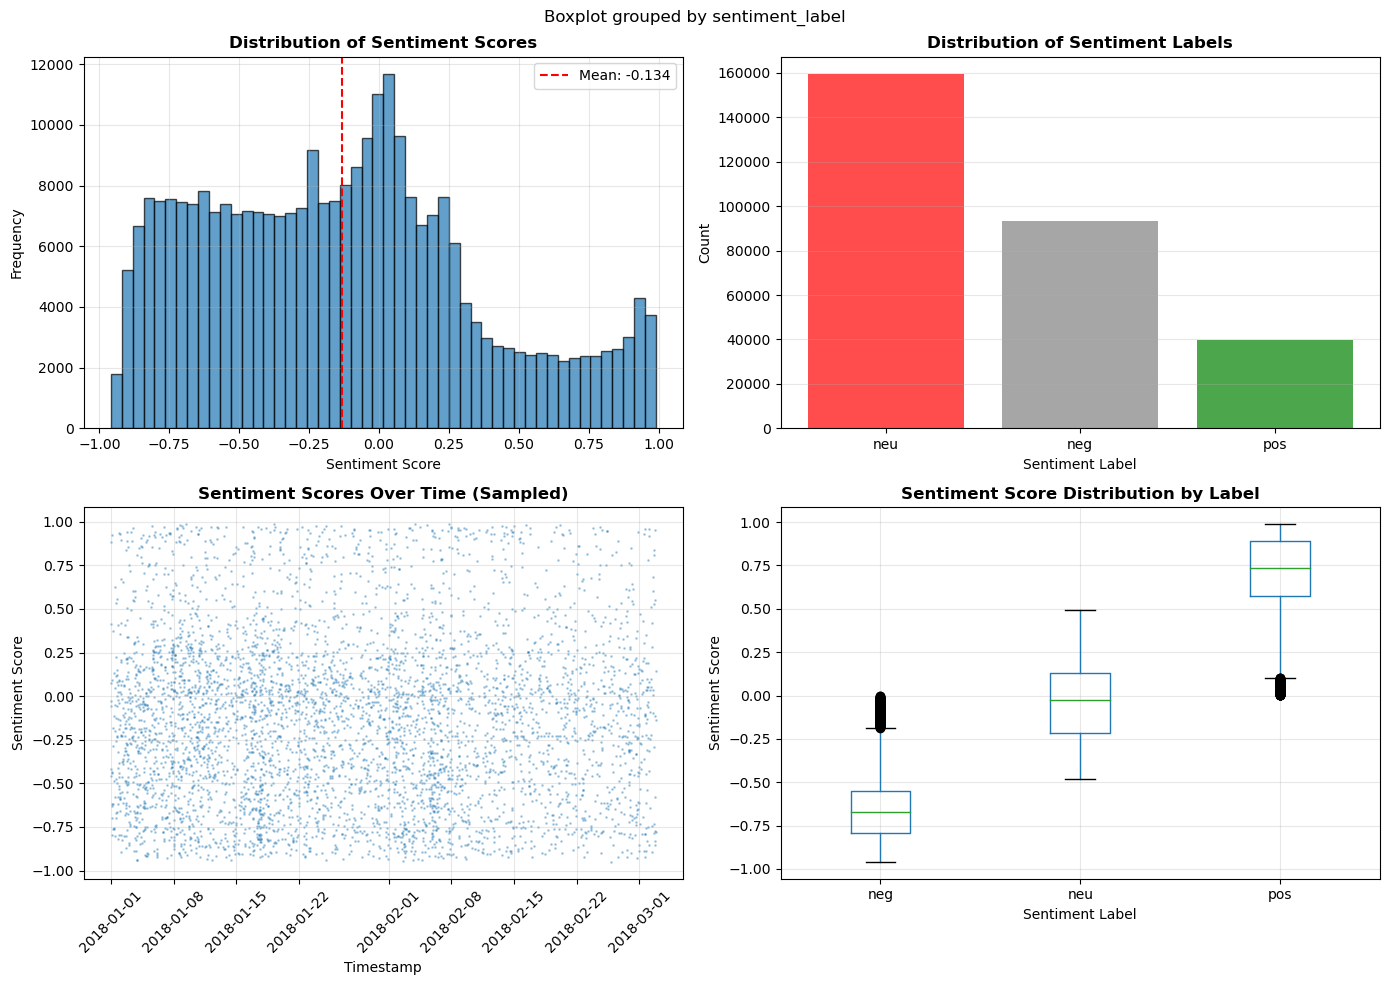

In [36]:
# Basic Visualizations - Reddit Sentiment Distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sentiment score distribution
axes[0, 0].hist(train1['sentiment_score'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Sentiment Scores', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Sentiment Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(train1['sentiment_score'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {train1["sentiment_score"].mean():.3f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Sentiment label distribution
sentiment_counts = train1['sentiment_label'].value_counts()
axes[0, 1].bar(sentiment_counts.index, sentiment_counts.values, color=['red', 'gray', 'green'], alpha=0.7)
axes[0, 1].set_title('Distribution of Sentiment Labels', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Sentiment Label')
axes[0, 1].set_ylabel('Count')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Sentiment over time (sample)
train1_sorted = train1.sort_values('timestamp')
sample_size = min(5000, len(train1_sorted))
sample_df = train1_sorted.iloc[::max(1, len(train1_sorted)//sample_size)]
axes[1, 0].scatter(sample_df['timestamp'], sample_df['sentiment_score'], alpha=0.3, s=1)
axes[1, 0].set_title('Sentiment Scores Over Time (Sampled)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Timestamp')
axes[1, 0].set_ylabel('Sentiment Score')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Box plot of sentiment by label
train1.boxplot(column='sentiment_score', by='sentiment_label', ax=axes[1, 1])
axes[1, 1].set_title('Sentiment Score Distribution by Label', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Sentiment Label')
axes[1, 1].set_ylabel('Sentiment Score')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


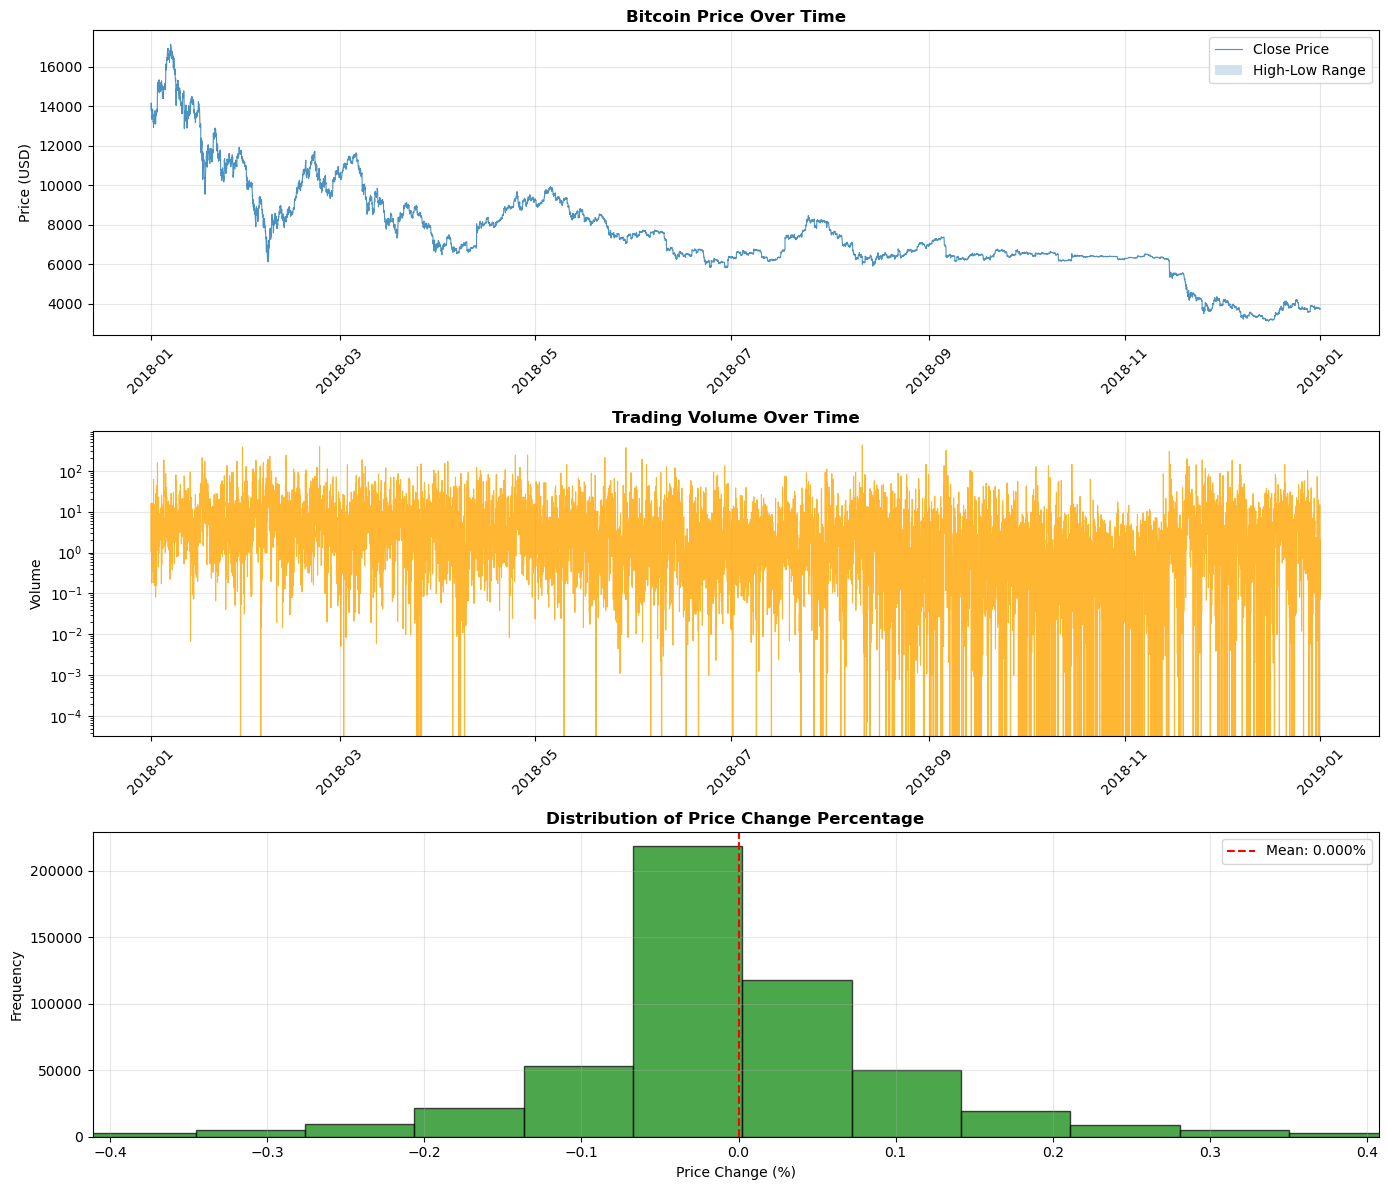

In [37]:
# Basic Visualizations - Bitcoin Price Analysis
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# derive extra columns to examine data better
if 'price_range' not in bitcoin.columns:
    bitcoin['price_range'] = bitcoin['high'] - bitcoin['low']
if 'price_change' not in bitcoin.columns:
    bitcoin['price_change'] = bitcoin['close'] - bitcoin['open']
if 'price_change_pct' not in bitcoin.columns:
    bitcoin['price_change_pct'] = ((bitcoin['close'] - bitcoin['open']) / bitcoin['open']) * 100

# Price over time (sample for performance)
bitcoin_sorted = bitcoin.sort_values('timestamp')
sample_size = min(10000, len(bitcoin_sorted))
sample_btc = bitcoin_sorted.iloc[::max(1, len(bitcoin_sorted)//sample_size)]

axes[0].plot(sample_btc['timestamp'], sample_btc['close'], linewidth=0.8, alpha=0.8, label='Close Price')
axes[0].fill_between(sample_btc['timestamp'], sample_btc['low'], sample_btc['high'], 
                      alpha=0.2, label='High-Low Range')
axes[0].set_title('Bitcoin Price Over Time', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price (USD)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Volume over time
axes[1].plot(sample_btc['timestamp'], sample_btc['volume'], linewidth=0.8, alpha=0.8, color='orange')
axes[1].set_title('Trading Volume Over Time', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Volume')
axes[1].set_yscale('log')  # Log scale for better visualization
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

# Price change distribution
axes[2].hist(bitcoin['price_change_pct'].dropna(), bins=100, edgecolor='black', alpha=0.7, color='green')
axes[2].set_title('Distribution of Price Change Percentage', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Price Change (%)')
axes[2].set_ylabel('Frequency')
axes[2].axvline(bitcoin['price_change_pct'].mean(), color='red', linestyle='--', 
                label=f"Mean: {bitcoin['price_change_pct'].mean():.3f}%")
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim(bitcoin['price_change_pct'].quantile(0.01), bitcoin['price_change_pct'].quantile(0.99))

plt.tight_layout()
plt.show()


In [38]:
#Summary Statistics Across All Datasets

print("SUMMARY STATISTICS ACROSS ALL DATASETS")

reddit_datasets = {
    'train1': train1,
    'train2': train2,
    'train3': train3,
    'train4': train4,
    'validate': validate,
    'test': test
}

summary_reddit = []
for name, df in reddit_datasets.items():
    summary_reddit.append({
        'Dataset': name,
        'Rows': len(df),
        'Mean_Sentiment': df['sentiment_score'].mean() if 'sentiment_score' in df.columns else None,
        'Std_Sentiment': df['sentiment_score'].std() if 'sentiment_score' in df.columns else None,
        'Min_Sentiment': df['sentiment_score'].min() if 'sentiment_score' in df.columns else None,
        'Max_Sentiment': df['sentiment_score'].max() if 'sentiment_score' in df.columns else None,
    })

summary_reddit_df = pd.DataFrame(summary_reddit)
print("\nReddit Datasets Summary:")
print(summary_reddit_df.to_string(index=False))

print("\nBitcoin Dataset Summary:")
print(f"Total rows: {len(bitcoin)}")
print(f"Price range: ${bitcoin['close'].min():.2f} - ${bitcoin['close'].max():.2f}")
print(f"Average price: ${bitcoin['close'].mean():.2f}")
print(f"Average volume: {bitcoin['volume'].mean():.2f}")
print(f"Average price change: {bitcoin['price_change_pct'].mean():.3f}%")

SUMMARY STATISTICS ACROSS ALL DATASETS

Reddit Datasets Summary:
 Dataset   Rows  Mean_Sentiment  Std_Sentiment  Min_Sentiment  Max_Sentiment
  train1 292404       -0.134011       0.483268      -0.958790       0.990065
  train2 162244       -0.145510       0.490568      -0.956314       0.989781
  train3 130209       -0.145599       0.491281      -0.955971       0.990305
  train4 109912       -0.146740       0.491605      -0.957382       0.988730
validate 108976       -0.174863       0.491667      -0.955814       0.989417
    test  86329       -0.142053       0.497146      -0.956429       0.989973

Bitcoin Dataset Summary:
Total rows: 525600
Price range: $3124.45 - $17234.98
Average price: $7530.37
Average volume: 7.48
Average price change: 0.000%


Here is what we have learnt:

- Reddit datasets contain sentiment scores ranging from -1 to 1
- Bitcoin data contains minute-level OHLCV data
- Time overlap between datasets: days
- Reddit sentiment distribution appears relatively balanced
- Bitcoin price shows volatility throughout the period

## Data Preprocessing

In [39]:
# combine reddit datasets
reddit = pd.concat([train1, train2, train3, train4, validate, test], ignore_index=True)
# timestamp to datetime
reddit['timestamp'] = pd.to_datetime(reddit['timestamp'])
# sort
reddit = reddit.sort_values('timestamp').set_index('timestamp')

reddit.head()


,sentiment_score,sentiment_label
timestamp,,
2018-01-01 00:00:14,0.074898,neu
2018-01-01 00:00:29,-0.914421,neg
2018-01-01 00:00:36,0.675613,pos
2018-01-01 00:00:58,0.966026,pos
2018-01-01 00:01:10,0.146835,neu


In [40]:
# also converst bitcoin timestamps
bitcoin['timestamp'] = pd.to_datetime(bitcoin['timestamp'])
bitcoin = bitcoin.sort_values('timestamp').set_index('timestamp')

Resample Reddit sentiment into the correct time intervals (1min, 10min, 24hours)

In [41]:
reddit_1m = reddit['sentiment_score'].resample('1T').mean().to_frame('sent_mean')
reddit_1m['sent_count'] = reddit['sentiment_score'].resample('1T').count()
reddit_1m['sent_std'] = reddit['sentiment_score'].resample('1T').std()
reddit_1m.head()

C:\Users\Emilie\AppData\Local\Temp\ipykernel_2280\169548857.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  reddit_1m = reddit['sentiment_score'].resample('1T').mean().to_frame('sent_mean')
C:\Users\Emilie\AppData\Local\Temp\ipykernel_2280\169548857.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  reddit_1m['sent_count'] = reddit['sentiment_score'].resample('1T').count()
C:\Users\Emilie\AppData\Local\Temp\ipykernel_2280\169548857.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  reddit_1m['sent_std'] = reddit['sentiment_score'].resample('1T').std()


,sent_mean,sent_count,sent_std
timestamp,,,
2018-01-01 00:00:00,0.200529,4,0.830780
2018-01-01 00:01:00,-0.015902,4,0.309069
2018-01-01 00:02:00,-0.188677,8,0.524255
2018-01-01 00:03:00,-0.023814,3,0.560652
2018-01-01 00:04:00,-0.538277,2,0.031257


In [42]:
reddit_10m = reddit['sentiment_score'].resample('10T').mean().to_frame('sent_mean')
reddit_10m['sent_count'] = reddit['sentiment_score'].resample('10T').count()
reddit_10m['sent_std'] = reddit['sentiment_score'].resample('10T').std()

C:\Users\Emilie\AppData\Local\Temp\ipykernel_2280\493430324.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  reddit_10m = reddit['sentiment_score'].resample('10T').mean().to_frame('sent_mean')
C:\Users\Emilie\AppData\Local\Temp\ipykernel_2280\493430324.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  reddit_10m['sent_count'] = reddit['sentiment_score'].resample('10T').count()
C:\Users\Emilie\AppData\Local\Temp\ipykernel_2280\493430324.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  reddit_10m['sent_std'] = reddit['sentiment_score'].resample('10T').std()


In [43]:
reddit_1d = reddit['sentiment_score'].resample('1D').mean().to_frame('sent_mean')
reddit_1d['sent_count'] = reddit['sentiment_score'].resample('1D').count()
reddit_1d['sent_std'] = reddit['sentiment_score'].resample('1D').std()


Now, we compute bitcoin returns and volatility

In [46]:
# create log returns
bitcoin['log_ret'] = np.log(bitcoin['close']).diff()

# for 1 minute
btc_1m = bitcoin['log_ret'].abs().to_frame('rv_1m')

# for 10 minutes
btc_10m = (bitcoin['log_ret']**2).resample('10T').sum().pow(0.5).to_frame('rv_10m')

# for 1 day
btc_1d = (bitcoin['log_ret']**2).resample('1D').sum().pow(0.5).to_frame('rv_1d')

C:\Users\Emilie\AppData\Local\Temp\ipykernel_2280\197716939.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  btc_10m = (bitcoin['log_ret']**2).resample('10T').sum().pow(0.5).to_frame('rv_10m')


Now we merge Sentiment with Volatility

In [47]:
df_1m = btc_1m.merge(reddit_1m, left_index=True, right_index=True, how='left')

df_10m = btc_10m.merge(reddit_10m, left_index=True, right_index=True, how='left')

df_1d = btc_1d.merge(reddit_1d, left_index=True, right_index=True, how='left')


In [ ]:
# Reddit doesn’t have posts every minute, so some intervals will be empty
df_1m = df_1m.fillna(method='ffill')
df_10m = df_10m.fillna(method='ffill')
df_1d = df_1d.fillna(method='ffill')


C:\Users\Emilie\AppData\Local\Temp\ipykernel_2280\3124939870.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_1m = df_1m.fillna(method='ffill')
C:\Users\Emilie\AppData\Local\Temp\ipykernel_2280\3124939870.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_10m = df_10m.fillna(method='ffill')
C:\Users\Emilie\AppData\Local\Temp\ipykernel_2280\3124939870.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_1d = df_1d.fillna(method='ffill')


## Bitcoin Volatility Measures

1 mimute volatility:
$RV^{(1m)}_t = |r_t|$

10 minutes volatility:
$RV^{(10m)}_t = \sqrt{\sum_{i=0}^{9} r_{t-i}^2}$


daily volatility:
$RV^{(1d)}_t = \sqrt{\sum_{i \in \text{day } t} r_i^2}$

In [49]:
# 1 minute realized volatility (absolute log return)
btc_1m = bitcoin['log_ret'].abs().to_frame('rv_1m')

# 10 minutes formula above
btc_10m = (
    (bitcoin['log_ret'] ** 2)
    .resample('10T')
    .sum()
    .pow(0.5)
    .to_frame('rv_10m')
)

# 1 day returns from above formula 
btc_1d = (
    (bitcoin['log_ret'] ** 2)
    .resample('1D')
    .sum()
    .pow(0.5)
    .to_frame('rv_1d')
)


C:\Users\Emilie\AppData\Local\Temp\ipykernel_2280\1073464033.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('10T')


In [50]:
# cleanup and check-up
btc_1m = btc_1m.dropna()
bitcoin['log_ret'] = bitcoin['log_ret'].fillna(0)

btc_1m.head(), btc_10m.head(), btc_1d.head()


(                        rv_1m
 timestamp                    
 2018-01-01 00:01:00  0.002147
 2018-01-01 00:02:00  0.000019
 2018-01-01 00:03:00  0.003161
 2018-01-01 00:04:00  0.000994
 2018-01-01 00:05:00  0.000356,
                        rv_10m
 timestamp                    
 2018-01-01 00:00:00  0.010016
 2018-01-01 00:10:00  0.006508
 2018-01-01 00:20:00  0.007151
 2018-01-01 00:30:00  0.013318
 2018-01-01 00:40:00  0.004444,
                rv_1d
 timestamp           
 2018-01-01  0.089043
 2018-01-02  0.082489
 2018-01-03  0.081668
 2018-01-04  0.074606
 2018-01-05  0.070581)

## Compute Bitcoin Returns + Volatility

In [54]:
# compute log returns
bitcoin['log_ret'] = np.log(bitcoin['close']).diff()

# drop the first NaN
bitcoin = bitcoin.dropna(subset=['log_ret'])

btc_1m = bitcoin['log_ret'].abs().to_frame('rv_1m') #1 minute

#10-minutes
btc_10m = (
    (bitcoin['log_ret']**2)
    .resample('10T')
    .sum()
    .pow(0.5)
    .to_frame('rv_10m')
)

#1 day
btc_1d = (
    (bitcoin['log_ret']**2)
    .resample('1D')
    .sum()
    .pow(0.5)
    .to_frame('rv_1d')
)


C:\Users\Emilie\AppData\Local\Temp\ipykernel_2280\4084204175.py:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('10T')


In [62]:
#check-ups
print(btc_1m.head())
print(btc_10m.head())
print(btc_1d.head())

                        rv_1m
timestamp                    
2018-01-01 00:01:00  0.002147
2018-01-01 00:02:00  0.000019
2018-01-01 00:03:00  0.003161
2018-01-01 00:04:00  0.000994
2018-01-01 00:05:00  0.000356
                       rv_10m
timestamp                    
2018-01-01 00:00:00  0.010016
2018-01-01 00:10:00  0.006508
2018-01-01 00:20:00  0.007151
2018-01-01 00:30:00  0.013318
2018-01-01 00:40:00  0.004444
               rv_1d
timestamp           
2018-01-01  0.089043
2018-01-02  0.082489
2018-01-03  0.081668
2018-01-04  0.074606
2018-01-05  0.070581


Simple correlation analysis first

In [63]:
def corr_summary(df, vol_col='rv_1m'):
    return pd.DataFrame({
        'Pearson': df[[vol_col, 'sent_mean']].corr(method='pearson').iloc[0,1],
        'Spearman': df[[vol_col, 'sent_mean']].corr(method='spearman').iloc[0,1]
    }, index=['Correlation'])


In [64]:
corr_1m = corr_summary(df_1m, vol_col='rv_1m')
corr_1m


,Pearson,Spearman
Correlation,-0.001538,0.005786


In [65]:
corr_10m = corr_summary(df_10m, vol_col='rv_10m')
corr_10m


,Pearson,Spearman
Correlation,-0.007576,0.001689


In [66]:
corr_1d = corr_summary(df_1d, vol_col='rv_1d')
corr_1d


,Pearson,Spearman
Correlation,-0.092318,-0.067282


From the above results, we see no significant correlation, although highest for the 1-day volatility

Lagged Correlations: does sentiment predict future volatility?

In [67]:
def lagged_corr(df, vol_col, max_lag=10):
    results = []
    for lag in range(1, max_lag+1):
        corr = df['sent_mean'].corr(df[vol_col].shift(-lag))
        results.append({'lag': lag, 'corr': corr})
    return pd.DataFrame(results)


In [68]:
lagcorr_1m = lagged_corr(df_1m, 'rv_1m', max_lag=10)
lagcorr_1m


,lag,corr
0,1,-0.002303
1,2,-0.002314
2,3,-0.003199
3,4,-0.003142
4,5,-0.002367
5,6,-0.002300
6,7,-0.000929
7,8,-0.003399
8,9,-0.002006
9,10,-0.001775


In [69]:
lagcorr_10m = lagged_corr(df_10m, 'rv_10m', max_lag=10)
lagcorr_10m


,lag,corr
0,1,-0.009361
1,2,-0.006108
2,3,-0.006317
3,4,-0.006403
4,5,-0.009414
5,6,-0.008045
6,7,-0.010826
7,8,-0.009941
8,9,-0.009362
9,10,-0.009248


In [70]:
lagcorr_1d = lagged_corr(df_1d, 'rv_1d', max_lag=5)  # 5 days ahead is enough
lagcorr_1d


,lag,corr
0,1,-0.092947
1,2,-0.056472
2,3,-0.058655
3,4,-0.067109
4,5,-0.025912


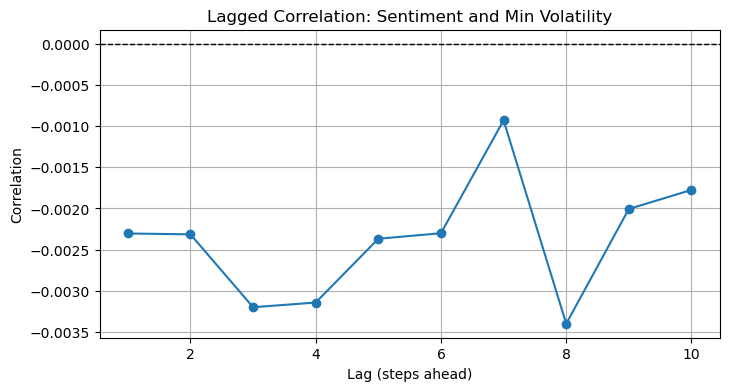

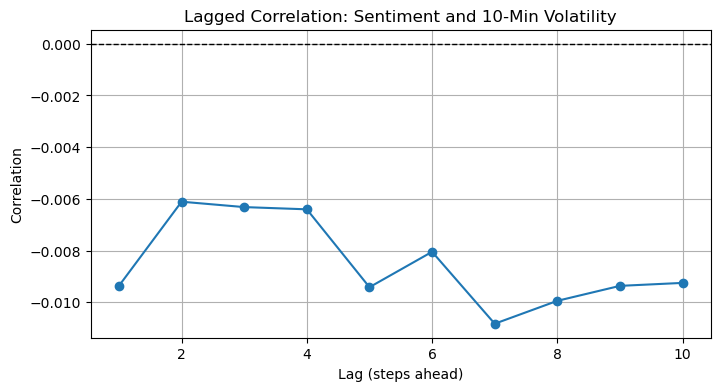

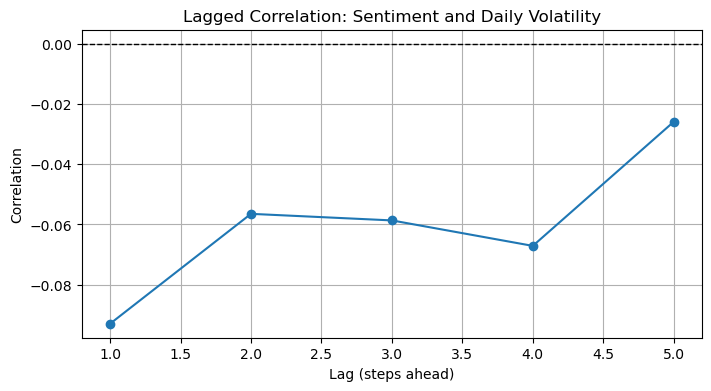

In [82]:
# let's visualise this data

def plot_lagged_corr(lagcorr_df, title):
    plt.figure(figsize=(8,4))
    plt.plot(lagcorr_df['lag'], lagcorr_df['corr'], marker='o')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlabel("Lag (steps ahead)")
    plt.ylabel("Correlation")
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_lagged_corr(lagcorr_1m, "Lagged Correlation: Sentiment and Min Volatility")
plot_lagged_corr(lagcorr_10m, "Lagged Correlation: Sentiment and 10-Min Volatility")
plot_lagged_corr(lagcorr_1d, "Lagged Correlation: Sentiment and Daily Volatility")


most significat correlation seen: negative correlation with a one-day lag

## Predictive Models

We model volatility as a function of its past value and Reddit sentiment.

Baseline model (no sentiment):

$RV_t = \alpha + \beta_1 RV_{t-1} + \varepsilon_t$

Model with sentiment:

$RV_t = \alpha + \beta_1 RV_{t-1} + \beta_2 \text{Sent}_t + \varepsilon_t$

If $\beta_2 \neq 0$ or the model fit improves, sentiment helps predict volatility.

In [72]:
#create lag feature

df_1m['rv_lag1'] = df_1m['rv_1m'].shift(1)
df_10m['rv_lag1'] = df_10m['rv_10m'].shift(1)
df_1d['rv_lag1'] = df_1d['rv_1d'].shift(1)

df_1m = df_1m.dropna()
df_10m = df_10m.dropna()
df_1d = df_1d.dropna()



OLS model

In [74]:
def run_ols(df, vol_col):
    # --- Baseline model: volatility only ---
    X_base = sm.add_constant(df[['rv_lag1']])
    y = df[vol_col]
    model_base = sm.OLS(y, X_base).fit()
    
    # --- Sentiment model: volatility + sentiment ---
    X_sent = sm.add_constant(df[['rv_lag1', 'sent_mean']])
    model_sent = sm.OLS(y, X_sent).fit()
    
    return model_base, model_sent


In [ ]:
m1_base, m1_sent = run_ols(df_1m, 'rv_1m')
m10_base, m10_sent = run_ols(df_10m, 'rv_10m')
md_base, md_sent = run_ols(df_1d, 'rv_1d')


In [78]:
def compare_models(base, sent):
    print("Baseline R²:", base.rsquared)
    print("Sentiment R²:", sent.rsquared)
    print("Δ R²:", sent.rsquared - base.rsquared)
    print("\nSentiment coefficient:")
    print(sent.params['sent_mean'])
    print("\nP-value for sentiment:")
    print(sent.pvalues['sent_mean'])


In [79]:
compare_models(m1_base, m1_sent)
compare_models(m10_base, m10_sent)
compare_models(md_base, md_sent)


Baseline R²: 0.1593583425682341
Sentiment R²: 0.1593591456486223
Δ R²: 8.030803881897697e-07

Sentiment coefficient:
-2.5612265794087943e-06

P-value for sentiment:
0.4785743383953841
Baseline R²: 0.5012128412601853
Sentiment R²: 0.501224425049817
Δ R²: 1.1583789631730568e-05

Sentiment coefficient:
-6.340448914716828e-05

P-value for sentiment:
0.26925106650601555
Baseline R²: 0.7055577240074085
Sentiment R²: 0.7131832486547959
Δ R²: 0.007625524647387416

Sentiment coefficient:
-0.07824001500312314

P-value for sentiment:
0.0021007390478738007


## Answer RQ: Does Reddit sentiment correlate with Bitcoin volatility in short time intervals (1-minute, 10-minute, next-day) during 2018–2019?

### 1-minute interval

ΔR² ≈ 0.0000008 (no improvement)
β₂ = –2.56 × 10⁻⁶
p = 0.48 (not significant)
Lag correlations ≈ 0

**Conclusion:**
Reddit sentiment does not correlate with or predict 1-minute Bitcoin volatility.


### 10-minute interval

ΔR² ≈ 0.000011 (effectively zero)
β₂ = –6.34 × 10⁻⁵
p = 0.27 (not significant)
Lag correlations ≈ 0

**Conclusion:**
No meaningful correlation or predictive power at the 10-minute interval.


### Next-day (1-day) interval

ΔR² ≈ 0.0076 (small improvement)
β₂ = –0.078
p = 0.002 (significant)
Lag Spearman ≈ –0.09 (weak)

**Conclusion:**
There is a statistically significant but very small relationship between daily sentiment and daily volatility, but the effect size is tiny (ΔR² < 1%).
Sentiment explains less than 1% of the variation in daily volatility.


### Overall Conclusion:

Reddit sentiment shows no meaningful correlation with Bitcoin volatility at 1-minute or 10-minute intervals, and although a small statistically significant effect appears at the daily scale, the predictive power is negligible, meaning Reddit sentiment does not practically predict Bitcoin volatility in 2018-2019.